In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from umap import UMAP

sns.set(style='ticks', context='notebook')

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from hivscc_data import load_data
import hivscc_analysis as utils
human_df, mouse_df, ephys_df, morph_df = load_data()

drop_neg = [
    'input_resistance',
    'fi_fit_slope',
    'sag'
]
for feat in drop_neg:
    mouse_df[feat] = mouse_df[feat].apply(lambda x: x if (x>0) else np.nan)
    human_df[feat] = human_df[feat].apply(lambda x: x if (x>0) else np.nan)

/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/pandas/core/common.py:329: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  return maybe_callable(obj, **kwargs)


In [3]:
palette = {
    'LTK': '#cfe818',
    'GLP2R': '#3db516',
    'FREM3': '#3263b0',
    'CARM1P1': '#6f2af7',
    'COL22A1': '#f057f0',
    'Agmat': '#D10034',
    'Rrad': '#F67415',
    'Adamts2': '#FFC800',
    ' ': 'k',
          }

In [4]:
# full t-type cluster name column
cluster = "SeuratMapping"

def plot_scatter(*args, legend=False, **kwargs):
    plt.figure(figsize=(4,4))
    sns.scatterplot(*args, legend=legend, 
                    s=25, **kwargs)
    sns.despine()
    plt.xticks([])
    plt.yticks([])

# Ephys

In [5]:
ephys_complete = ephys_df[ephys_df.notna().mean(axis=1)>0.80]
combined = (pd.concat([human_df[human_df[cluster].str.contains("Exc L2")], 
                      mouse_df], sort=False)
    .join(ephys_complete, how='inner', rsuffix='r')
    .sample(frac=1, random_state=42)
)
X = combined[ephys_df.columns].values
types = combined.species.astype('category')
y = types.cat.codes
types.value_counts()

human    235
mouse    120
Name: species, dtype: int64

Text(0.5, 1.0, 'UMAP')

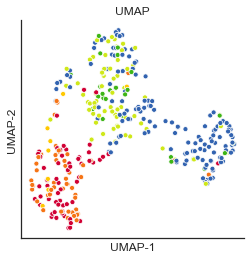

In [6]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer()),
    ('decomp', UMAP(random_state=42))
])

Y = pipeline.fit_transform(X)
plot_scatter(-Y[:,0], Y[:,1], hue=combined.cluster, palette=palette)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title("UMAP")
# plt.savefig('/home/tom.chartrand/figs/f4_ephys_umap.pdf', bbox_inches='tight', pad_inches=0)

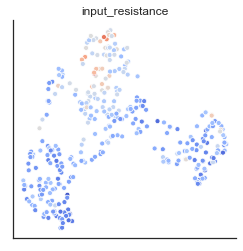

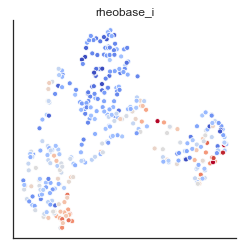

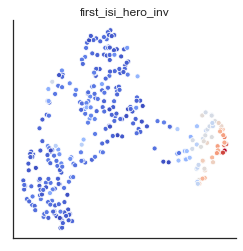

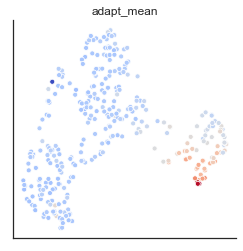

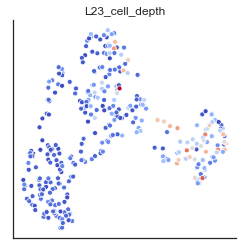

In [7]:
# feature overlays
feats = [
    "input_resistance",
    "rheobase_i",
    "first_isi_hero_inv",
    "adapt_mean",
    "L23_cell_depth"
]
for feat in feats:
    plot_scatter(-Y[:,0], Y[:,1], hue=combined[feat], palette="coolwarm", legend=False)
    plt.title(feat)

Text(0.5, 0, '$\\longleftarrow$ f-I slope   init freq, adapt, sag $\\longrightarrow$')

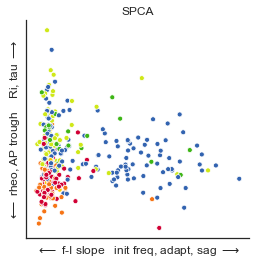

In [8]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer()),
    ('decomp', SparsePCA(n_components=2, alpha=6))
])

Y = pipeline.fit_transform(X)

plot_scatter(-Y[:,0], -Y[:,1], hue=combined.cluster, palette=palette)
plt.title("SPCA")
plt.ylabel(r'$\longleftarrow$ rheo, AP trough    Ri, tau $\longrightarrow$')
plt.xlabel(r'$\longleftarrow$ f-I slope   init freq, adapt, sag $\longrightarrow$')
# plt.savefig('/home/tom.chartrand/figs/f4_ephys_spca.pdf', bbox_inches='tight', pad_inches=0)

In [9]:
cls = pipeline.named_steps["decomp"]

weights = pd.DataFrame(cls.components_.T, ephys_df.columns)
weights.loc[weights.sum(axis=1)!=0,:].iloc[lambda df: (-df[1].abs()).argsort()]

,0,1
tau,0.000000,-0.618505
input_resistance,0.000000,-0.615229
rheobase_i,0.000000,0.378708
fast_trough_v_long_square_rel,0.000000,0.308779
upstroke_downstroke_ratio_long_square,0.000000,0.013426
adapt_mean,-0.637988,0.000000
fi_fit_slope,0.048649,0.000000
first_isi_hero_inv,-0.766012,0.000000
latency_rheo,0.004339,0.000000
sag,-0.061734,0.000000


# Morph

In [10]:
morph = morph_df.drop(columns=[x for x in morph_df.columns if "pc_" in x or "depth" in x])

combined = (pd.concat([human_df[human_df[cluster].str.contains("Exc L2")], 
                      mouse_df], sort=False)
            .join(morph, how='inner', rsuffix='r')
    .sample(frac=1, random_state=42)
)
X = combined[morph.columns].values
types = combined.species.astype('category')
y = types.cat.codes
types.value_counts()

human    94
mouse    60
Name: species, dtype: int64

Text(0, 0.5, 'UMAP-2')

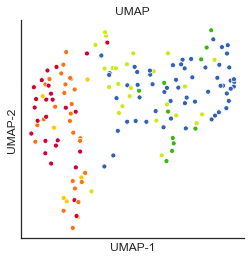

In [11]:
pipeline = Pipeline(steps=[
    ('norm', StandardScaler()),
    ('impute', KNNImputer()),
    ('decomp', UMAP(random_state=42))
])
Y = pipeline.fit_transform(X)

plot_scatter(-Y[:,0], Y[:,1], hue=combined.cluster, palette=palette)
plt.title('UMAP')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
# plt.savefig('/home/tom.chartrand/figs/f4_morph_umap.pdf', bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'basal total size')

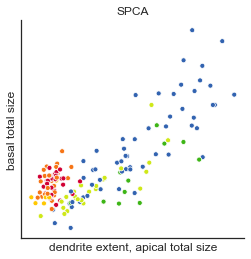

In [12]:
pipeline = Pipeline(steps=[
    ('norm', StandardScaler()),
    ('impute', KNNImputer()),
    ('decomp', SparsePCA(n_components=2, alpha=9))
])
Y = pipeline.fit_transform(X)

plot_scatter(-Y[:,0], Y[:,1], hue=combined.cluster, palette=palette)
plt.title('SPCA')
plt.xlabel('dendrite extent, apical total size')
plt.ylabel('basal total size')
# plt.savefig('/home/tom.chartrand/figs/f4_morph_spca.pdf', bbox_inches='tight', pad_inches=0)

In [13]:
cls = pipeline.named_steps["decomp"]

weights = pd.DataFrame(cls.components_.T, morph.columns)
weights.loc[weights.sum(axis=1)!=0,:].iloc[lambda df: (-df[0].abs()).argsort()]

,0,1
apical_dendrite_max_path_distance_none,-0.388794,0.000000
apical_dendrite_max_euclidean_distance_none,-0.388454,0.000000
apical_dendrite_extent_y,-0.379652,0.000000
apical_dendrite_bias_y,-0.362898,0.000000
basal_dendrite_emd_with_apical_dendrite_none,-0.285143,0.000000
basal_dendrite_extent_x,-0.283280,0.000000
basal_dendrite_max_euclidean_distance_none,-0.278071,0.000000
apical_dendrite_total_length_none,-0.267044,0.000000
basal_dendrite_max_path_distance_none,-0.234440,0.000000
apical_dendrite_total_surface_none,-0.209850,0.000000


## All types ephys

In [14]:
ephys_complete = ephys_df[ephys_df.notna().mean(axis=1)>0.80]
combined = (pd.concat([human_df, mouse_df], sort=False)
            .join(ephys_complete, how='inner', rsuffix='r')
    .sample(frac=1, random_state=42)
)
X = combined[ephys_df.columns].values
types = combined.species.astype('category')
y = types.cat.codes
types.value_counts()

human    283
mouse    120
Name: species, dtype: int64

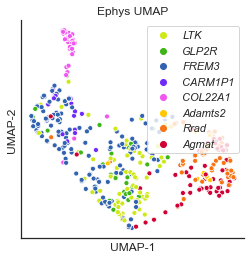

In [15]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer()),
    ('decomp', UMAP(random_state=42))
])

Y = pipeline.fit_transform(X)
plot_scatter(*Y.T, hue=combined.cluster, palette=palette, legend='full')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title("Ephys UMAP")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], prop=dict(style='italic'))

Text(0, 0.5, '$\\longleftarrow$ init freq, adapt, sag   latency $\\longrightarrow$')

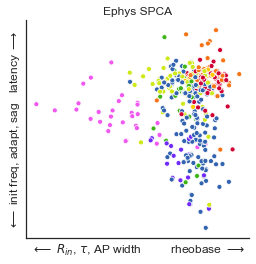

In [16]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer()),
    ('decomp', SparsePCA(n_components=2, alpha=5))
])

Y = pipeline.fit_transform(X)
plot_scatter(Y[:,0], Y[:,1], hue=combined.cluster, palette=palette)

plt.title("Ephys SPCA")
plt.xlabel(r'$\longleftarrow$ $R_{in}$, $\tau$, AP width         rheobase $\longrightarrow$')
plt.ylabel(r'$\longleftarrow$ init freq, adapt, sag   latency $\longrightarrow$')

In [17]:
cls = pipeline.named_steps["decomp"]

weights = pd.DataFrame(cls.components_.T, ephys_df.columns)
weights.loc[weights.sum(axis=1)!=0,:].iloc[lambda df: (-df[0].abs()).argsort()]

,0,1
input_resistance,-0.794152,0.000000
tau,-0.464046,0.000000
rheobase_i,0.268941,0.000000
width_long_square,-0.244538,0.000000
v_baseline,-0.118861,-0.024515
downstroke_long_square,-0.058748,0.000000
fast_trough_v_long_square_rel,0.056137,0.000000
upstroke_long_square,0.033546,0.000000
adapt_mean,0.000000,-0.655335
fi_fit_slope,0.000000,0.079129


# All types morph

In [18]:
combined = (pd.concat([human_df, mouse_df], sort=False)
            .join(morph, how='inner', rsuffix='r')
    .sample(frac=1, random_state=42)
)
X = combined[morph.columns].values
types = combined.species.astype('category')
y = types.cat.codes
types.value_counts()

human    109
mouse     60
Name: species, dtype: int64

Text(0.5, 1.0, 'Morph UMAP')

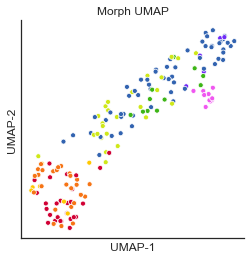

In [19]:
pipeline = Pipeline(steps=[
    ('norm', StandardScaler()),
    ('impute', KNNImputer()),
    ('decomp', UMAP(random_state=42))
])
Y = pipeline.fit_transform(X)

plot_scatter(*-Y.T, hue=combined.cluster, palette=palette)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title("Morph UMAP")

Text(0.5, 1.0, 'Morph SPCA')

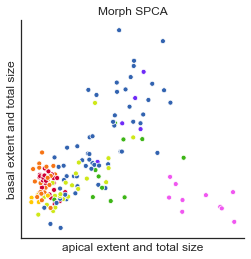

In [20]:
pipeline = Pipeline(steps=[
    ('norm', StandardScaler()),
    ('impute', KNNImputer()),
    ('decomp', SparsePCA(n_components=2, alpha=10))
])
Y = pipeline.fit_transform(X)

plot_scatter(*-Y.T, hue=combined.cluster, palette=palette)
plt.xlabel('apical extent and total size')
plt.ylabel('basal extent and total size')
plt.title("Morph SPCA")

In [21]:
cls = pipeline.named_steps["decomp"]

weights = pd.DataFrame(cls.components_.T, morph.columns)
weights.loc[weights.sum(axis=1)!=0,:].iloc[lambda df: (-df[0].abs()).argsort()]

,0,1
apical_dendrite_max_euclidean_distance_none,-0.465503,0.000000
apical_dendrite_max_path_distance_none,-0.462285,0.000000
apical_dendrite_bias_y,-0.460544,0.000000
apical_dendrite_extent_y,-0.456705,0.000000
basal_dendrite_emd_with_apical_dendrite_none,-0.381268,0.000000
apical_dendrite_over_basal_dendrite_extent_y,-0.059622,0.000000
basal_dendrite_extent_x,0.000000,-0.140641
basal_dendrite_total_length_none,0.000000,-0.546605
basal_dendrite_total_surface_none,0.000000,-0.623994
basal_dendrite_total_volume_none,0.000000,-0.540440


# Human ephys space with patient metadata

In [25]:
pipeline = Pipeline(steps=[
    ('norm', RobustScaler()),
    ('impute', KNNImputer(weights='distance')),
    ('class', UMAP(random_state=42))
])
combined = (human_df.join(ephys_complete, how='inner', rsuffix='r')
    .sample(frac=1, random_state=42)
)
combined.cluster.cat.remove_unused_categories(inplace=True)
X = combined[ephys_df.columns].values
Y = pipeline.fit_transform(X)

types = combined.cluster.astype('category')
types.value_counts()

FREM3      143
LTK         67
COL22A1     31
GLP2R       25
CARM1P1     17
Name: cluster, dtype: int64

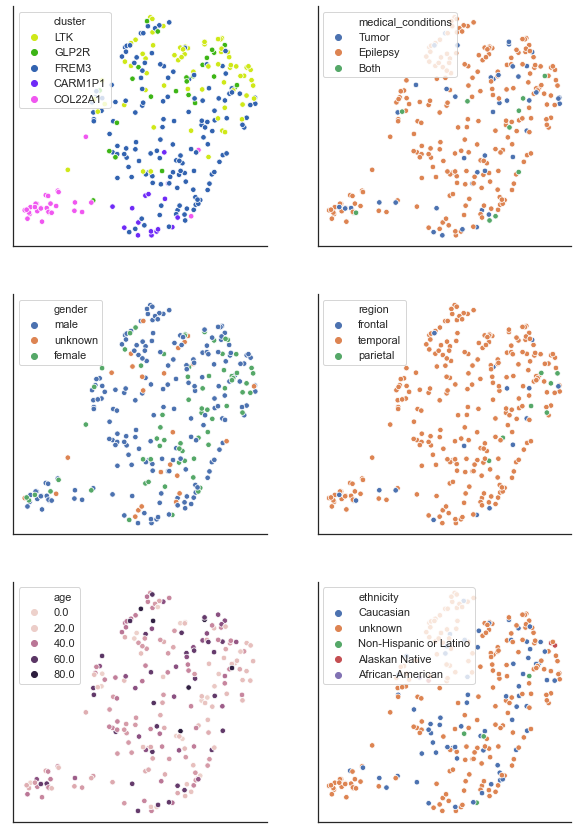

In [26]:
variables = [
    combined.cluster,
    combined.medical_conditions,
    combined.gender,
    combined.region,
    combined.age,
    combined.ethnicity.replace("not specified", "unknown")
]
fig, axs = plt.subplots(3,2, figsize=(10,15), sharex=True, sharey=True)
axs = axs.ravel()
for i, var in enumerate(variables):
    ax = axs[i]
    sns.scatterplot(*Y.T, hue=var, legend='brief', s=30, ax=ax, palette=palette if i==0 else None)
    sns.despine()
    ax.set_xticks([])
    ax.set_yticks([])